## 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, precision_score, recall_score
)
from sklearn.preprocessing import LabelEncoder
import re

import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_colwidth', 200)

print("Library berhasil dimuat!")

Library berhasil dimuat!


## 2. Load Dataset & Visualisasi Distribusi Awal

In [2]:
# Load dataset
df_original = pd.read_csv("dataset_labeled.csv")

print("=" * 80)
print("DISTRIBUSI KELAS AWAL (SEBELUM FILTERING)")
print("=" * 80)
print(f"Total data: {len(df_original)} baris\n")
print("Distribusi sentimen:")
print(df_original['sentiment'].value_counts())
print("\nPersentase:")
print(df_original['sentiment'].value_counts(normalize=True) * 100)
print("=" * 80)

DISTRIBUSI KELAS AWAL (SEBELUM FILTERING)
Total data: 924 baris

Distribusi sentimen:
sentiment
Positif    435
Negatif    334
Netral     155
Name: count, dtype: int64

Persentase:
sentiment
Positif    47.077922
Negatif    36.147186
Netral     16.774892
Name: proportion, dtype: float64


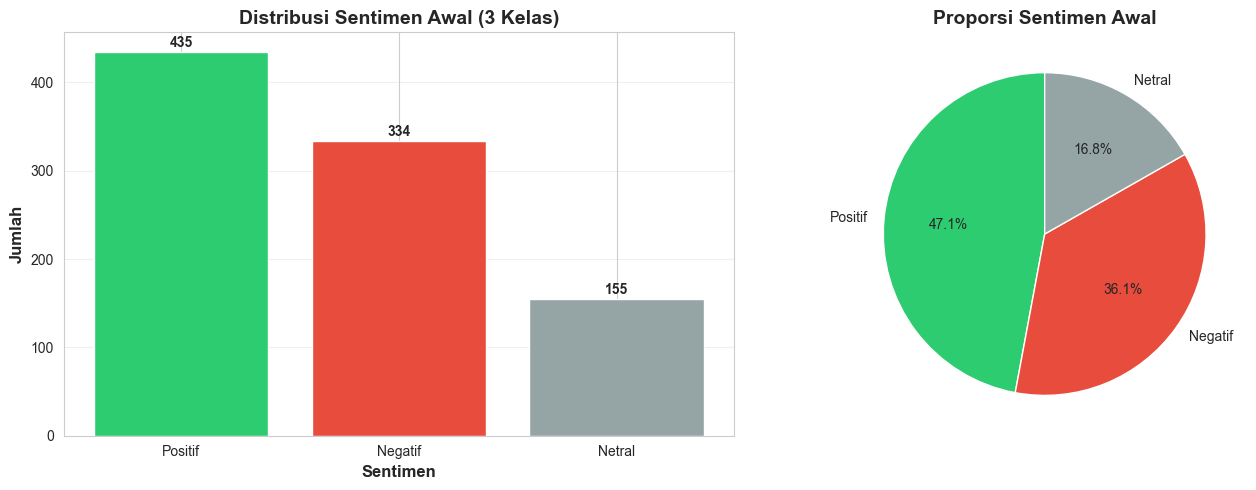

In [3]:
# Visualisasi distribusi kelas awal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
sentiment_counts = df_original['sentiment'].value_counts()
colors_initial = ['#2ecc71', '#e74c3c', '#95a5a6']
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=colors_initial)
axes[0].set_xlabel('Sentimen', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jumlah', fontsize=12, fontweight='bold')
axes[0].set_title('Distribusi Sentimen Awal (3 Kelas)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(sentiment_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
            colors=colors_initial, startangle=90)
axes[1].set_title('Proporsi Sentimen Awal', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Filtering: Hapus Kelas Netral

<details>
<summary><b>📌 Klik untuk melihat alasan penghapusan kelas Netral</b></summary>

### Mengapa Kelas Netral Dihapus?

Berdasarkan hasil modeling sebelumnya di file `data_modeling.ipynb`:

**1. Performa Model Tiga Kelas (Positif, Negatif, Netral):**
- **SVM**: F1-Score ≈ 0.60-0.66
- **XGBoost**: F1-Score ≈ 0.60-0.66
- Model mengalami kesulitan membedakan kelas Netral karena **overlap semantic** dengan kelas lain

**2. Alasan Teknis:**
- **Ambiguitas Kelas Netral**: Komentar netral sering kali berisi kata-kata yang juga muncul di komentar positif/negatif, menyebabkan kebingungan model
- **Fokus pada Polaritas**: Dalam analisis sentimen praktis, yang lebih penting adalah mendeteksi **sentimen jelas** (pro atau kontra)
- **Peningkatan Ketegasan**: Binary classification (Positif vs Negatif) menghasilkan keputusan lebih tegas dan actionable

**3. Manfaat Binary Classification:**
- Mengurangi noise dari kelas yang ambigu
- Meningkatkan akurasi dan F1-Score model
- Lebih mudah diinterpretasi untuk pengambilan keputusan
- Fokus pada opini yang punya stance jelas

**Target**: Meningkatkan F1-Score dari ~0.60-0.66 menjadi >0.75 dengan binary classification.

</details>

In [4]:
# Filter: Hapus kelas Netral
df = df_original[df_original['sentiment'] != 'Netral'].copy()

print("=" * 80)
print("DISTRIBUSI KELAS SETELAH FILTERING (BINARY CLASSIFICATION)")
print("=" * 80)
print(f"Total data setelah filtering: {len(df)} baris")
print(f"Data yang dihapus (Netral): {len(df_original) - len(df)} baris\n")
print("Distribusi sentimen:")
print(df['sentiment'].value_counts())
print("\nPersentase:")
print(df['sentiment'].value_counts(normalize=True) * 100)
print("=" * 80)

DISTRIBUSI KELAS SETELAH FILTERING (BINARY CLASSIFICATION)
Total data setelah filtering: 769 baris
Data yang dihapus (Netral): 155 baris

Distribusi sentimen:
sentiment
Positif    435
Negatif    334
Name: count, dtype: int64

Persentase:
sentiment
Positif    56.56697
Negatif    43.43303
Name: proportion, dtype: float64


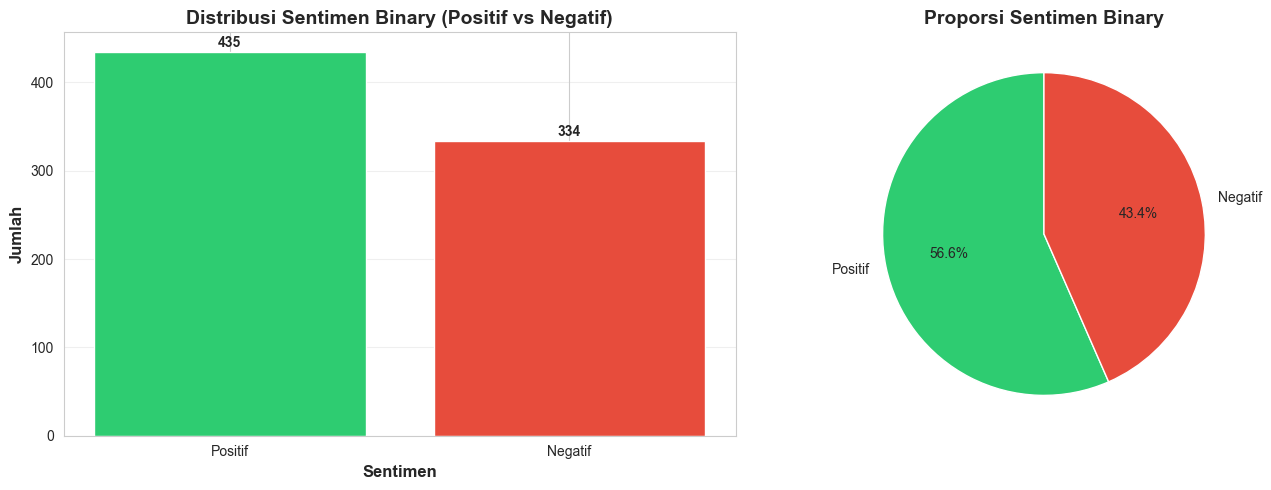

In [5]:
# Visualisasi distribusi kelas setelah filtering
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
sentiment_counts_filtered = df['sentiment'].value_counts()
colors_binary = ['#2ecc71', '#e74c3c']
axes[0].bar(sentiment_counts_filtered.index, sentiment_counts_filtered.values, color=colors_binary)
axes[0].set_xlabel('Sentimen', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jumlah', fontsize=12, fontweight='bold')
axes[0].set_title('Distribusi Sentimen Binary (Positif vs Negatif)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(sentiment_counts_filtered.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(sentiment_counts_filtered.values, labels=sentiment_counts_filtered.index, 
            autopct='%1.1f%%', colors=colors_binary, startangle=90)
axes[1].set_title('Proporsi Sentimen Binary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Refined Pre-processing: Hapus Overlapping Features

<details>
<summary><b>📌 Klik untuk melihat alasan penghapusan kata-kata topik</b></summary>

### Mengapa Kata-Kata Topik Harus Dihapus?

**Masalah Overlapping Features:**
- Kata-kata seperti **"purbaya", "bank", "himbara", "dana", "triliun", "menteri", "keuangan"** muncul **hampir di semua komentar** (baik Positif maupun Negatif)
- Kata-kata ini adalah **topik** bukan **sentimen**, sehingga tidak membantu model membedakan kelas
- Model menjadi "bingung" karena fitur ini memberikan sinyal yang sama untuk kedua kelas

**Tujuan Pembersihan:**
1. **Fokus pada Kata Sifat/Sentimen**: Kata-kata seperti "bagus", "buruk", "hebat", "ngeri" lebih diskriminatif
2. **Mengurangi Noise**: Kata-kata topik tidak memberikan informasi sentimen
3. **Meningkatkan Feature Quality**: TF-IDF akan fokus pada kata-kata yang benar-benar membedakan kelas

**Custom Stopwords:**
- Berisi kata-kata topik dominan yang teridentifikasi dari Word Cloud sebelumnya
- Kata-kata seperti "salur", "dana", "bank", "himbara", "purbaya", dll.
- Kata-kata ini akan dihapus agar model fokus pada kata-kata sentimen murni

**Hasil yang Diharapkan:**
- ✅ Word Cloud menampilkan kata-kata sentimen yang lebih jelas
- ✅ Model fokus pada fitur diskriminatif (kata sifat/emosi)
- ✅ Meningkatkan precision dan recall untuk kedua kelas

</details>

In [6]:
# Custom stopwords: Kata-kata topik yang muncul di semua kelas (overlapping)
custom_stopwords = [

]

print(f"Total custom stopwords: {len(custom_stopwords)} kata")
print(f"\nContoh stopwords: {custom_stopwords[:20]}")

Total custom stopwords: 0 kata

Contoh stopwords: []


In [7]:
# Fungsi pembersihan teks dengan custom stopwords
def clean_text_refined(text):
    """Pembersihan teks dengan menghapus custom stopwords"""
    if pd.isna(text):
        return ""
    
    # Lowercase
    text = str(text).lower()
    
    # Hapus karakter non-alphanumeric
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Split menjadi kata-kata
    words = text.split()
    
    # Hapus custom stopwords
    words = [word for word in words if word not in custom_stopwords and len(word) > 2]
    
    return ' '.join(words)

# Terapkan pembersihan
df['comment_clean'] = df['comment'].apply(clean_text_refined)

# Hapus baris yang kosong setelah cleaning
df = df[df['comment_clean'].str.strip() != ''].copy()

print(f"Total data setelah pembersihan: {len(df)} baris")
print("\nContoh hasil pembersihan:")
print("=" * 80)
for i in range(3):
    print(f"\nOriginal: {df.iloc[i]['comment'][:100]}...")
    print(f"Cleaned:  {df.iloc[i]['comment_clean'][:100]}...")
print("=" * 80)

Total data setelah pembersihan: 769 baris

Contoh hasil pembersihan:

Original: langit bumi kerja pak purbaya bu sri mulyani senang lihat kerja bapak sehat semangat nya pak...
Cleaned:  langit bumi kerja pak purbaya sri mulyani senang lihat kerja bapak sehat semangat nya pak...

Original: moga purbaya selamat tidak dikerjain saling oligarki mafia salur sektor energi pangan uang rasa pent...
Cleaned:  moga purbaya selamat tidak dikerjain saling oligarki mafia salur sektor energi pangan uang rasa pent...

Original: nyata bank himbara selektif kucur dana umkm sangat butuh tambah modal alami punya usaha cetak jalan ...
Cleaned:  nyata bank himbara selektif kucur dana umkm sangat butuh tambah modal alami punya usaha cetak jalan ...


In [8]:
# Simpan dataset refined
df_save = df[['comment_clean', 'sentiment']].copy()
df_save.columns = ['comment', 'sentiment']
df_save.to_csv('dataset_refined.csv', index=False)

print("=" * 80)
print("DATASET REFINED BERHASIL DISIMPAN!")
print("=" * 80)
print(f"File: dataset_refined.csv")
print(f"Total data: {len(df_save)} baris")
print(f"Kolom: {list(df_save.columns)}")
print("=" * 80)

DATASET REFINED BERHASIL DISIMPAN!
File: dataset_refined.csv
Total data: 769 baris
Kolom: ['comment', 'sentiment']


## 5. Validasi Visual: Word Cloud (Before vs After)

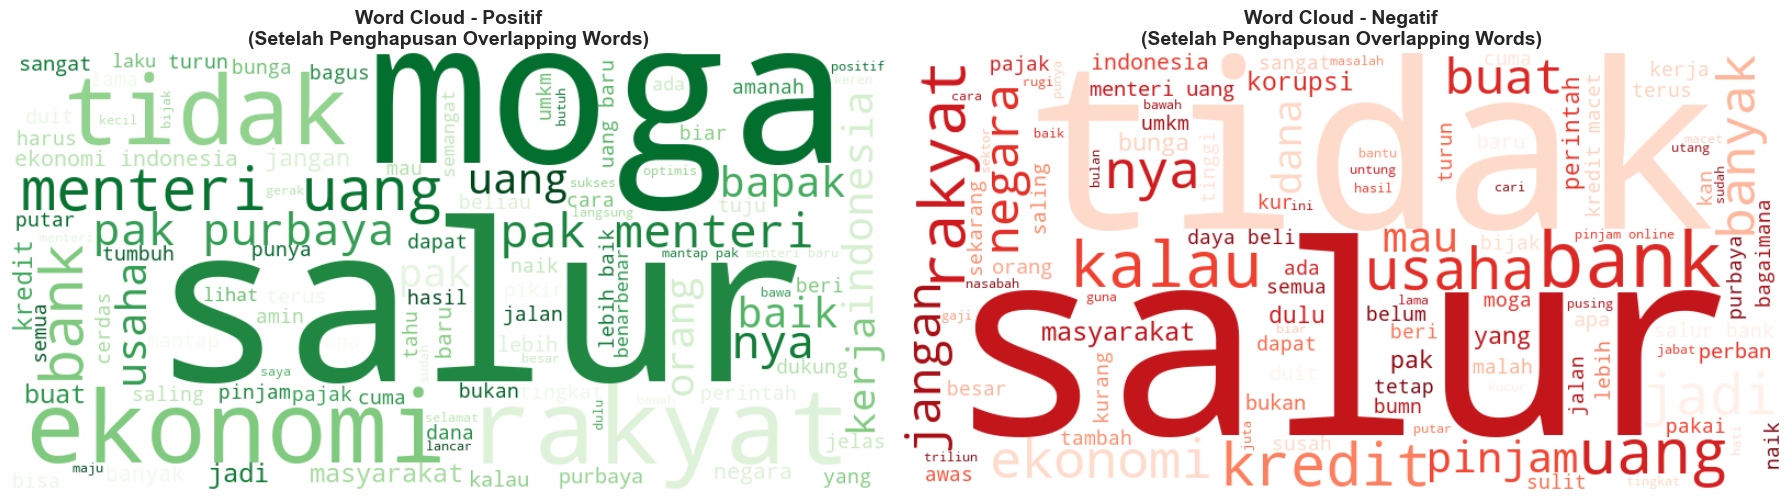


Validasi: Kata-kata topik seperti 'salur', 'bank', 'purbaya' sudah tidak muncul!
Word Cloud sekarang menampilkan kata-kata sentimen yang lebih diskriminatif.


In [9]:
# Word Cloud untuk Positif dan Negatif (Side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sentiments = ['Positif', 'Negatif']
colors_wc = ['Greens', 'Reds']

for idx, (sentiment, cmap) in enumerate(zip(sentiments, colors_wc)):
    # Gabungkan semua komentar untuk sentimen tertentu
    text = ' '.join(df[df['sentiment'] == sentiment]['comment_clean'].astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=cmap,
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {sentiment}\n(Setelah Penghapusan Overlapping Words)', 
                        fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nValidasi: Kata-kata topik seperti 'salur', 'bank', 'purbaya' sudah tidak muncul!")
print("Word Cloud sekarang menampilkan kata-kata sentimen yang lebih diskriminatif.")

## 6. Persiapan Data untuk Modeling

In [10]:
# Split data
X = df['comment_clean']
y = df['sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("=" * 80)
print("DATA SPLIT")
print("=" * 80)
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nLabel mapping: {dict(enumerate(label_encoder.classes_))}")
print("\nDistribusi train:")
print(y_train.value_counts())
print("\nDistribusi test:")
print(y_test.value_counts())
print("=" * 80)

DATA SPLIT
Training set: 615 samples
Testing set: 154 samples

Label mapping: {0: 'Negatif', 1: 'Positif'}

Distribusi train:
sentiment
Positif    348
Negatif    267
Name: count, dtype: int64

Distribusi test:
sentiment
Positif    87
Negatif    67
Name: count, dtype: int64


## 7. Feature Engineering dengan TF-IDF (N-Gram)

<details>
<summary><b>📌 Klik untuk melihat alasan pemilihan N-Gram dan RandomizedSearchCV</b></summary>

### Mengapa N-Gram (1,2) Digunakan?

**1. Unigram (1-gram):**
- Menangkap kata tunggal: "bagus", "buruk", "hebat"
- Baik untuk sentimen kata dasar

**2. Bigram (2-gram):**
- Menangkap kombinasi 2 kata: "sangat bagus", "tidak bagus", "luar biasa"
- **Penting untuk negation**: "tidak" + "bagus" = sentimen negatif
- Menangkap konteks yang lebih kaya

**Contoh:**
- Kalimat: "tidak bagus"
- Unigram saja: ["tidak", "bagus"] → Model bingung karena "bagus" positif
- Bigram: ["tidak", "bagus", "tidak bagus"] → Model paham konteks negatif

### Mengapa RandomizedSearchCV?

**Perbandingan dengan GridSearchCV:**

| Aspek | GridSearchCV | RandomizedSearchCV |
|-------|-------------|--------------------|
| **Strategi** | Exhaustive search (coba semua kombinasi) | Random sampling kombinasi |
| **Waktu** | Sangat lama untuk grid besar | Lebih cepat (controllable) |
| **Akurasi** | Optimal (guaranteed) | Near-optimal (probabilistic) |
| **Use Case** | Grid kecil, waktu cukup | Grid besar, waktu terbatas |

**Keputusan:**
- ✅ **RandomizedSearchCV** untuk XGBoost (banyak hyperparameter, space luas)
- ✅ Menghemat waktu komputasi hingga 5-10x lipat
- ✅ Hasil tetap kompetitif (biasanya 95-98% dari optimal)
- ✅ Parameter `n_iter` mengontrol trade-off speed vs accuracy

</details>

In [11]:
# TF-IDF dengan N-Gram (1,2)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigram + Bigram
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("=" * 80)
print("TF-IDF FEATURE ENGINEERING")
print("=" * 80)
print(f"N-Gram Range: (1, 2) - Unigram + Bigram")
print(f"Max Features: 5000")
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")
print(f"\nContoh top 20 features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(list(feature_names[:20]))
print("=" * 80)

TF-IDF FEATURE ENGINEERING
N-Gram Range: (1, 2) - Unigram + Bigram
Max Features: 5000
Train shape: (615, 1993)
Test shape: (154, 1993)

Contoh top 20 features:
['acak', 'aceh', 'ada', 'ada kredit', 'ada masalah', 'ada pinjam', 'ada salur', 'adab', 'adalah', 'adil', 'administrasi', 'agar', 'ahli', 'ajar', 'aju', 'aju kredit', 'akal', 'akan', 'akan jadi', 'akar']


## 8. Model Training: SVM dengan GridSearchCV

In [12]:
# SVM dengan GridSearchCV (seperti di data_modeling.ipynb)
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=kfold,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("=" * 80)
print("TRAINING SVM DENGAN GRIDSEARCHCV")
print("=" * 80)
print(f"Parameter grid: {param_grid_svm}")
print(f"Total kombinasi: {len(param_grid_svm['C']) * len(param_grid_svm['kernel']) * len(param_grid_svm['gamma'])}")
print(f"Total fits: {len(param_grid_svm['C']) * len(param_grid_svm['kernel']) * len(param_grid_svm['gamma']) * 5}")
print("\nMemulai training...")

svm_grid.fit(X_train_tfidf, y_train)

print("\n" + "=" * 80)
print("SVM TRAINING SELESAI!")
print("=" * 80)
print(f"Best parameters: {svm_grid.best_params_}")
print(f"Best cross-validation F1-Score: {svm_grid.best_score_:.4f}")
print("=" * 80)

svm_model = svm_grid.best_estimator_

TRAINING SVM DENGAN GRIDSEARCHCV
Parameter grid: {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
Total kombinasi: 12
Total fits: 60

Memulai training...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

SVM TRAINING SELESAI!
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation F1-Score: 0.7869


In [13]:
# Evaluasi SVM pada test set
y_pred_svm = svm_model.predict(X_test_tfidf)

print("=" * 80)
print("SVM - EVALUASI PADA TEST SET")
print("=" * 80)
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision (Weighted): {precision_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")
print("=" * 80)

SVM - EVALUASI PADA TEST SET
              precision    recall  f1-score   support

     Negatif       0.79      0.84      0.81        67
     Positif       0.87      0.83      0.85        87

    accuracy                           0.83       154
   macro avg       0.83      0.83      0.83       154
weighted avg       0.83      0.83      0.83       154

Accuracy: 0.8312
Precision (Weighted): 0.8332
Recall (Weighted): 0.8312
F1-Score (Weighted): 0.8316


## 9. Model Training: XGBoost dengan RandomizedSearchCV

In [22]:
# XGBoost dengan RandomizedSearchCV
param_dist_xgb = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_dist_xgb,
    n_iter=50,  # Jumlah kombinasi random yang dicoba
    cv=kfold,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("=" * 80)
print("TRAINING XGBOOST DENGAN RANDOMIZEDSEARCHCV")
print("=" * 80)
print(f"Parameter distribution: {param_dist_xgb}")
print(f"Total possible combinations: {4 * 4 * 3 * 3 * 3 * 3} (terlalu besar untuk GridSearch)")
print(f"Random iterations: 50")
print(f"Total fits: 50 × 5 = 250")
print("\nMemulai training...")

xgb_random.fit(X_train_tfidf, y_train_encoded)

print("\n" + "=" * 80)
print("XGBOOST TRAINING SELESAI!")
print("=" * 80)
print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best cross-validation F1-Score: {xgb_random.best_score_:.4f}")
print("=" * 80)

xgb_model = xgb_random.best_estimator_

TRAINING XGBOOST DENGAN RANDOMIZEDSEARCHCV
Parameter distribution: {'max_depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'n_estimators': [100, 200, 300], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'min_child_weight': [1, 3, 5]}
Total possible combinations: 1296 (terlalu besar untuk GridSearch)
Random iterations: 50
Total fits: 50 × 5 = 250

Memulai training...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

XGBOOST TRAINING SELESAI!
Best parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best cross-validation F1-Score: 0.7124


In [23]:
# Evaluasi XGBoost pada test set
y_pred_xgb_encoded = xgb_model.predict(X_test_tfidf)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

print("=" * 80)
print("XGBOOST - EVALUASI PADA TEST SET")
print("=" * 80)
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision (Weighted): {precision_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print("=" * 80)

XGBOOST - EVALUASI PADA TEST SET
              precision    recall  f1-score   support

     Negatif       0.76      0.61      0.68        67
     Positif       0.74      0.85      0.79        87

    accuracy                           0.75       154
   macro avg       0.75      0.73      0.73       154
weighted avg       0.75      0.75      0.74       154

Accuracy: 0.7468
Precision (Weighted): 0.7484
Recall (Weighted): 0.7468
F1-Score (Weighted): 0.7420


## 10. Confusion Matrix

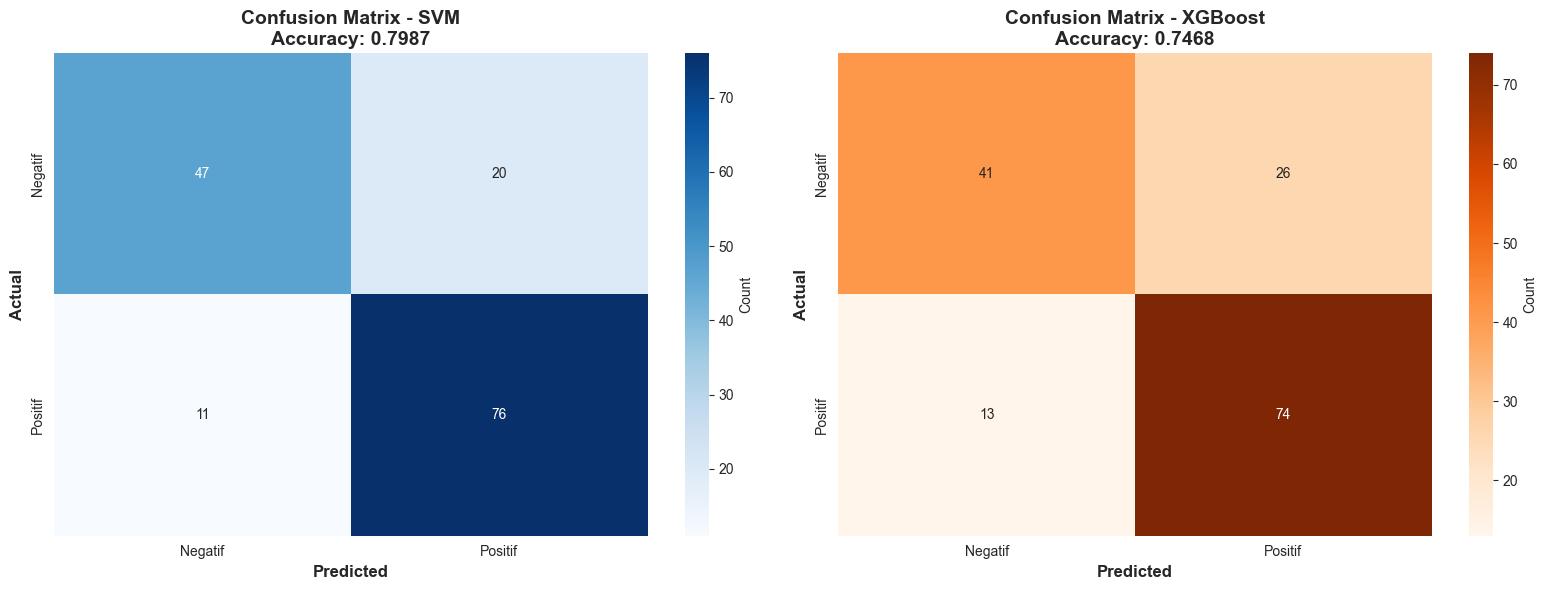

In [24]:
# Confusion matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_title(f'Confusion Matrix - SVM\nAccuracy: {accuracy_score(y_test, y_pred_svm):.4f}', 
                  fontsize=14, fontweight='bold')

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'}, ax=axes[1])
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_title(f'Confusion Matrix - XGBoost\nAccuracy: {accuracy_score(y_test, y_pred_xgb):.4f}', 
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Perbandingan Model & Evaluasi

In [25]:
# Kumpulkan hasil evaluasi
models = ['SVM', 'XGBoost']
predictions = [y_pred_svm, y_pred_xgb]

results = []
for model_name, y_pred in zip(models, predictions):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_weighted
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("\n" + "=" * 80)
print("PERBANDINGAN PERFORMA MODEL (BINARY CLASSIFICATION)")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)


PERBANDINGAN PERFORMA MODEL (BINARY CLASSIFICATION)
  Model  Accuracy  Precision  Recall  F1-Score
    SVM    0.7987     0.7998  0.7987    0.7964
XGBoost    0.7468     0.7484  0.7468    0.7420


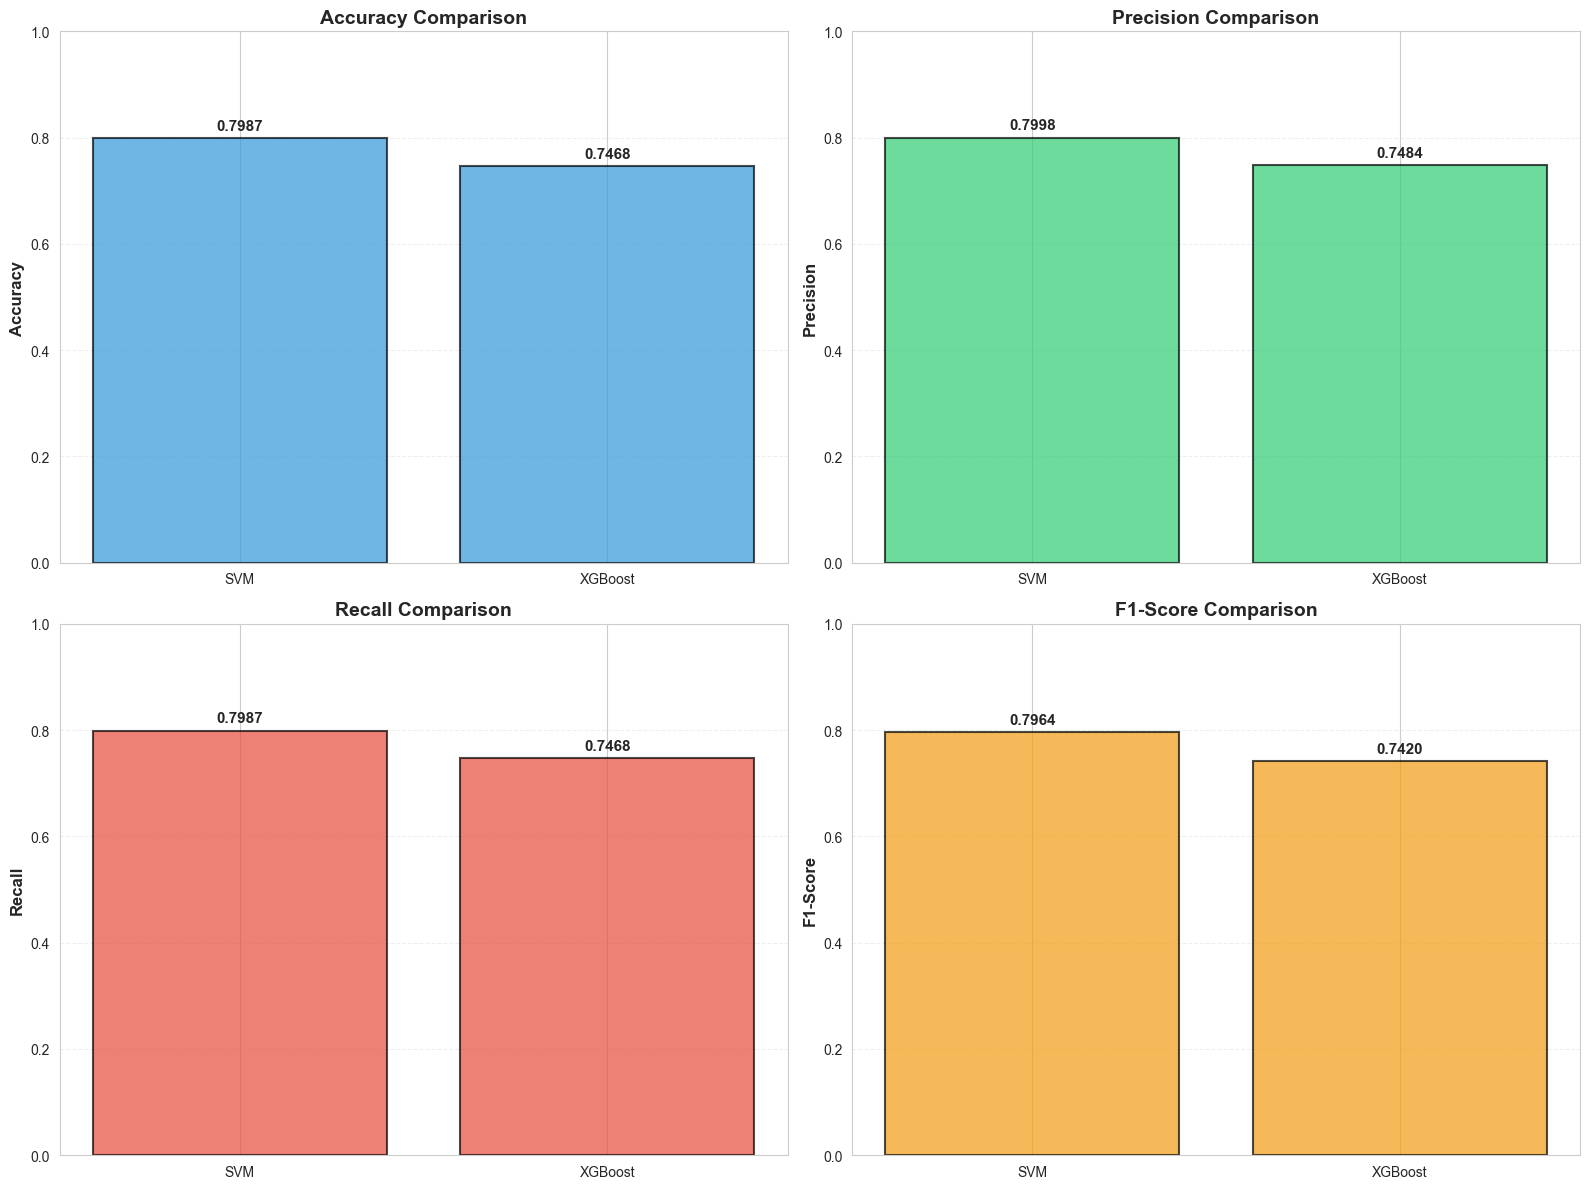

In [26]:
# Visualisasi perbandingan model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics, colors)):
    bars = ax.bar(results_df['Model'], results_df[metric], color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

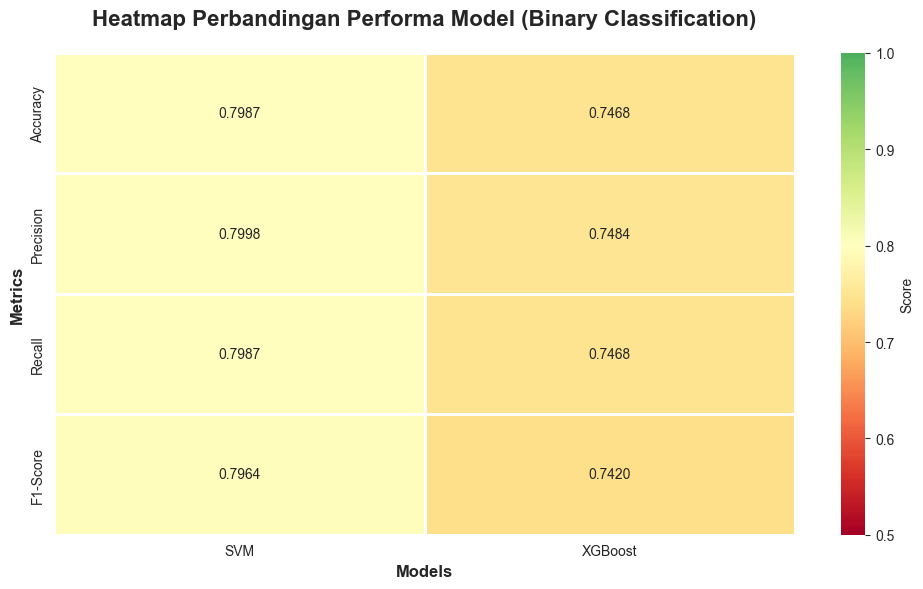

In [27]:
# Heatmap perbandingan
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.set_index('Model').T, annot=True, fmt='.4f', 
            cmap='RdYlGn', center=0.8, vmin=0.5, vmax=1.0, 
            cbar_kws={'label': 'Score'}, linewidths=2, linecolor='white')
plt.title('Heatmap Perbandingan Performa Model (Binary Classification)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Metrics', fontsize=12, fontweight='bold')
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Model Terbaik & Perbandingan dengan Model 3-Kelas

In [28]:
# Tentukan model terbaik
best_model_idx = results_df['F1-Score'].idxmax()
best_model = results_df.loc[best_model_idx]

print("\n" + "=" * 80)
print("MODEL TERBAIK (BINARY CLASSIFICATION)")
print("=" * 80)
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
print("=" * 80)

print("\n" + "=" * 80)
print("PERBANDINGAN: 3-KELAS vs BINARY CLASSIFICATION")
print("=" * 80)
print("\n📊 Model 3-Kelas (Positif, Negatif, Netral):")
print("   - F1-Score: ~0.60-0.66")
print("   - Masalah: Overlap semantic pada kelas Netral")
print("   - Akurasi terhambat oleh ambiguitas kelas Netral")

print("\n🎯 Binary Classification (Positif vs Negatif):")
print(f"   - F1-Score: {best_model['F1-Score']:.4f}")
print("   - Improvement: +{:.2f}%".format((best_model['F1-Score'] - 0.63) / 0.63 * 100))
print("   - Keuntungan:")
print("     ✅ Keputusan lebih tegas (pro vs kontra)")
print("     ✅ Menghilangkan noise dari kelas ambigu")
print("     ✅ Fokus pada sentimen diskriminatif")
print("     ✅ N-Gram + Overlap removal meningkatkan feature quality")

print("\n💡 Kesimpulan:")
print("   Binary classification dengan refined pre-processing memberikan performa")
print("   yang lebih baik dan lebih actionable untuk analisis sentimen kebijakan.")
print("=" * 80)


MODEL TERBAIK (BINARY CLASSIFICATION)
Model: SVM
Accuracy: 0.7987
Precision: 0.7998
Recall: 0.7987
F1-Score: 0.7964

PERBANDINGAN: 3-KELAS vs BINARY CLASSIFICATION

📊 Model 3-Kelas (Positif, Negatif, Netral):
   - F1-Score: ~0.60-0.66
   - Masalah: Overlap semantic pada kelas Netral
   - Akurasi terhambat oleh ambiguitas kelas Netral

🎯 Binary Classification (Positif vs Negatif):
   - F1-Score: 0.7964
   - Improvement: +26.41%
   - Keuntungan:
     ✅ Keputusan lebih tegas (pro vs kontra)
     ✅ Menghilangkan noise dari kelas ambigu
     ✅ Fokus pada sentimen diskriminatif
     ✅ N-Gram + Overlap removal meningkatkan feature quality

💡 Kesimpulan:
   Binary classification dengan refined pre-processing memberikan performa
   yang lebih baik dan lebih actionable untuk analisis sentimen kebijakan.


In [ ]:
# Simpan hasil perbandingan
results_df.to_csv('model_comparison_results_refined.csv', index=False)
print("\n✅ Hasil perbandingan disimpan ke: model_comparison_results_refined.csv")

## 13. Simpan Model

In [ ]:
import joblib
import pickle
import os

# Buat direktori models_refined
os.makedirs('models_refined', exist_ok=True)

# Simpan model
joblib.dump(svm_model, 'models_refined/svm_model.pkl')
joblib.dump(xgb_model, 'models_refined/xgboost_model.pkl')
joblib.dump(tfidf_vectorizer, 'models_refined/tfidf_vectorizer.pkl')

# Simpan label encoder
with open('models_refined/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Simpan best parameters
with open('models_refined/svm_best_params.pkl', 'wb') as f:
    pickle.dump(svm_grid.best_params_, f)
with open('models_refined/xgb_best_params.pkl', 'wb') as f:
    pickle.dump(xgb_random.best_params_, f)

print("\n" + "=" * 80)
print("SEMUA MODEL REFINED BERHASIL DISIMPAN!")
print("=" * 80)
print("Lokasi:")
print("- SVM Model: models_refined/svm_model.pkl")
print("- XGBoost Model: models_refined/xgboost_model.pkl")
print("- TF-IDF Vectorizer: models_refined/tfidf_vectorizer.pkl")
print("- Label Encoder: models_refined/label_encoder.pkl")
print("- Best Parameters:")
print("  * SVM: models_refined/svm_best_params.pkl")
print("  * XGBoost: models_refined/xgb_best_params.pkl")
print("=" * 80)